# Normalization of YZ- and XZ views in anisotropic image stacks

In this notebook, I will explore normalization of YZ- and XZ views in anisotropic image stacks

In [1]:
%matplotlib inline
import numpy as np
import theano
import matplotlib.pyplot as plt

from process import Process

cmap = plt.cm.gray

In [2]:
process = Process()
img_input,img_labels = process.read_in_images(["train-input"],["train-labels"])
img = img_input[0]

In [3]:
def avg(img_input,stride=6):
    def average(img):
        img_avg = np.zeros(img.shape)
        avg = np.mean(img,axis=0)

        for n in xrange(img.shape[0]):
            img_avg[n] = avg 

        return img_avg
    
    img = img_input[0]

    img_avg = np.zeros(img.shape)
    for n in xrange(0,img.shape[0],stride):
        img_avg[n:n+stride] = average(img[n:n+stride])
    return img_avg

def exp_(img_input,stride=6):
    def expand(i,stride):
        out = np.zeros((stride,i.shape[0]))
        for n in xrange(stride):
            out[n] = i
        return out
    
    img_xz = img_input[:,0,:]
    img_xz_avg = np.zeros((img_xz.shape[0]*stride,img_xz.shape[1]))
    for n in xrange(img_xz.shape[0]):
        img_xz_avg[stride*n:stride*(n+1)] = expand(img_xz[n],stride)
    return img_xz_avg

To get a reference, I load an image stack without normalization. I average over 6 and 6 rows to get a "fake" anisotropic version and compare it to a real anisotropic version.

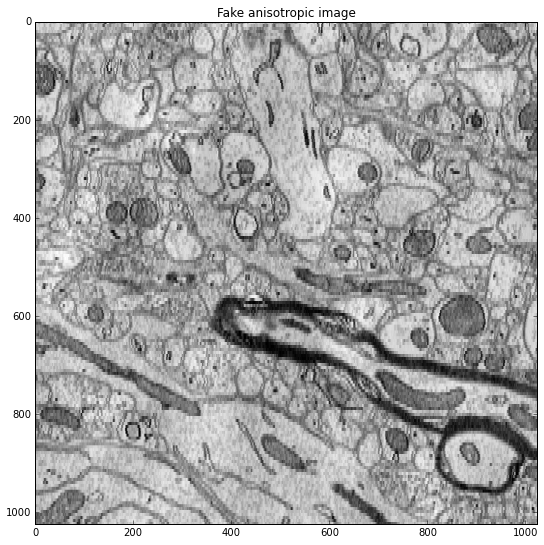

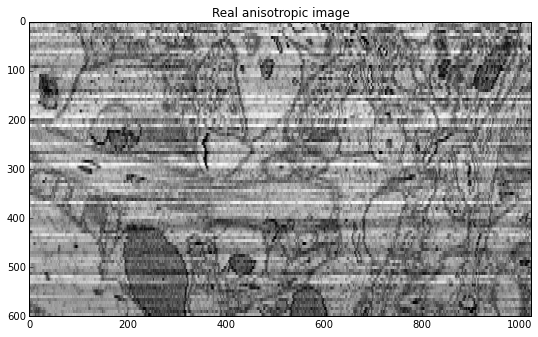

In [4]:
plt.figure(figsize=(9,9))
plt.title("Fake anisotropic image")
plt.imshow(avg(img_input),cmap=cmap)
plt.figure(figsize=(9,9))
plt.title("Real anisotropic image")
plt.imshow(exp_(img_input),cmap=cmap)

From this image, the horizontal stripes tells us that the image stack is not properly normalized.

In [5]:
def normalize(img):
    for n in xrange(img.shape[0]):
        img[n] -= img[n].mean()
        img[n] /= img[n].std()
    return img

img_input = normalize(img_input)

I therefore try a standard normalization where I substract the mean and divide by the standard deviation

$$\boldsymbol{x} = \frac{\boldsymbol{x}-\overline{\boldsymbol{x}}}{\sigma} $$

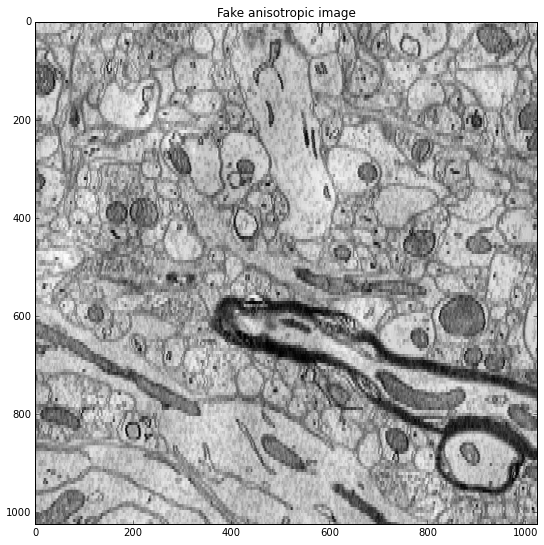

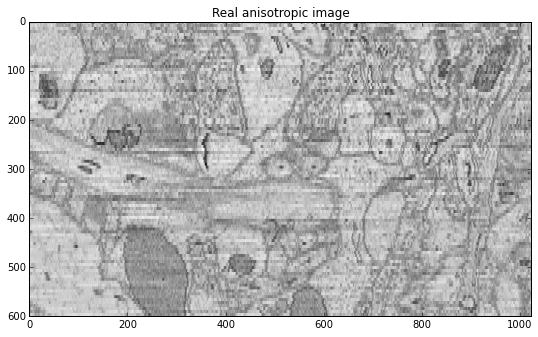

In [6]:
plt.figure(figsize=(9,9))
plt.title("Fake anisotropic image")
plt.imshow(avg(img_input),cmap=cmap)
plt.figure(figsize=(9,9))
plt.title("Real anisotropic image")
plt.imshow(exp_(img_input),cmap=cmap)

With normalization, we see that the anisotropic version looks better, but that the image don't seem to have the right contrast. I therefore try a [histogram equalization](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html) on separate images of the stack. By doing this, I get the following result:

In [7]:
import cv2
img_input,img_labels = process.read_in_images(["train-input"],["train-labels"])
img = img_input[0]

cdf_normalized = np.zeros(img_input.shape)
for n in xrange(img_input.shape[0]):
    cdf_normalized[n] = cv2.equalizeHist(img_input[n].astype(np.uint8))

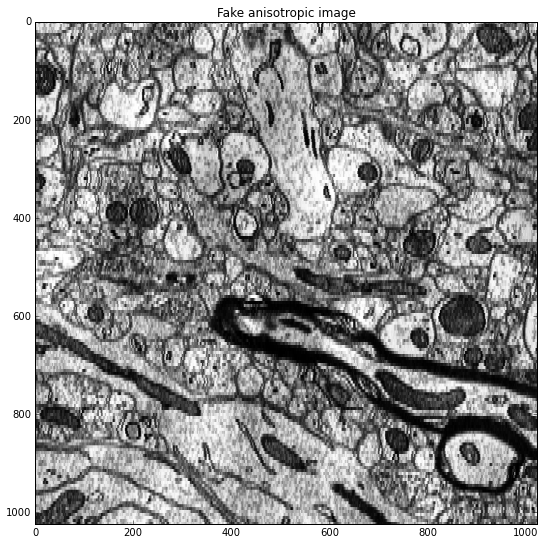

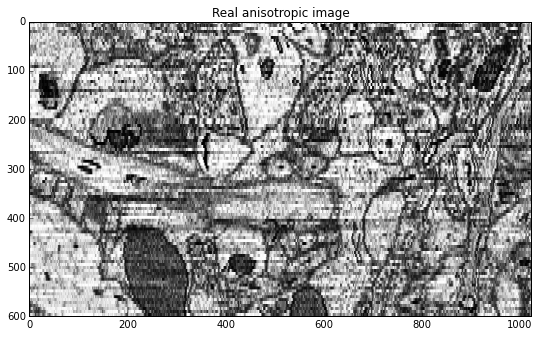

In [8]:
plt.figure(figsize=(9,9))
plt.title("Fake anisotropic image")
plt.imshow(avg(cdf_normalized),cmap=cmap)
plt.figure(figsize=(9,9))
plt.title("Real anisotropic image")
plt.imshow(exp_(cdf_normalized),cmap=cmap)

The anisotropic image looks closer to the "fake" anisotropic image, but we still see some horizontal defects and noise. Another idea is to try a localized version of histogram equalization called [Contrast Limited Adaptive Histogram Equalization](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html) or CLAHE. By appling this we get the following result:

In [9]:
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(15,15))

clahe_normalized = np.zeros(img_input.shape)
for n in xrange(img_input.shape[0]):
    clahe_normalized[n] =  clahe.apply(img_input[n].astype(np.uint8))

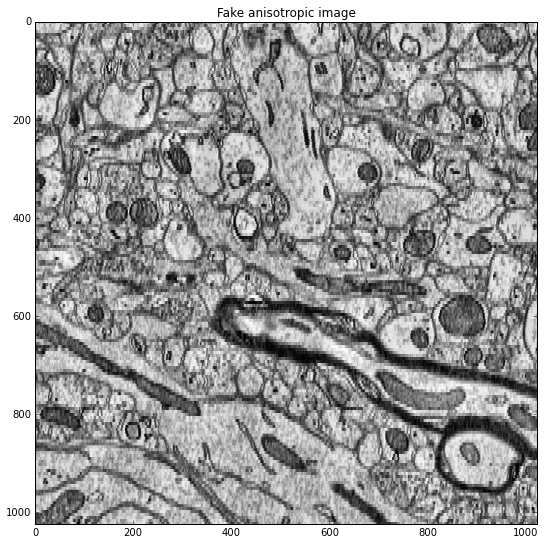

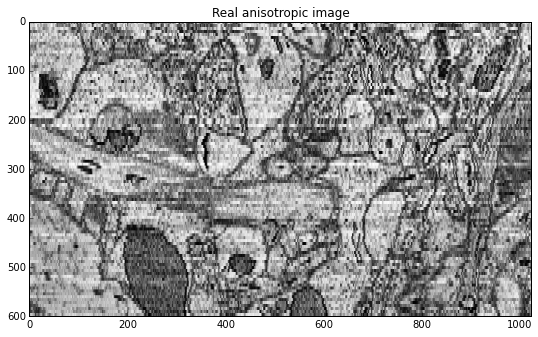

In [10]:
plt.figure(figsize=(9,9))
plt.title("Fake anisotropic image")
plt.imshow(avg(clahe_normalized),cmap=cmap)
plt.figure(figsize=(9,9))
plt.title("Real anisotropic image")
plt.imshow(exp_(clahe_normalized),cmap=cmap)

This result looks better. Note that CLAHE has two tunable parameters, clip limit and kernel size. By modifying these parameters we get slightly different results. For example, tuning down the clip limit, I get the following result:

In [11]:
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(15,15))

clahe_normalized = np.zeros(img_input.shape)
for n in xrange(img_input.shape[0]):
    clahe_normalized[n] =  clahe.apply(img_input[n].astype(np.uint8))

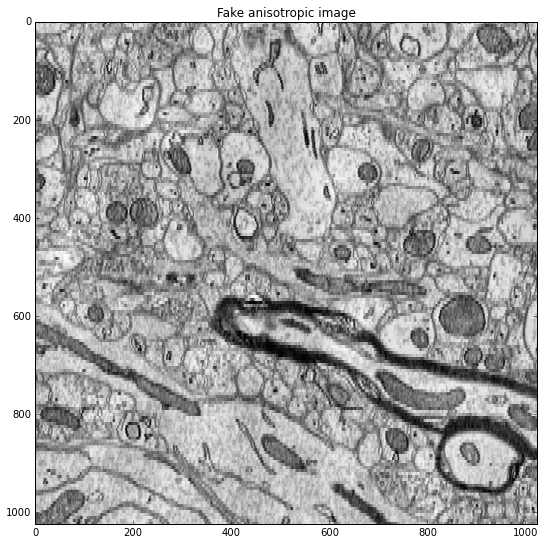

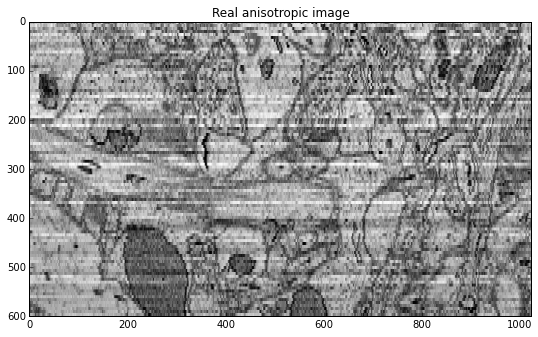

In [12]:
plt.figure(figsize=(9,9))
plt.title("Fake anisotropic image")
plt.imshow(avg(clahe_normalized),cmap=cmap)
plt.figure(figsize=(9,9))
plt.title("Real anisotropic image")
plt.imshow(exp_(clahe_normalized),cmap=cmap)

We see that by reducing the clip limit, we start seeing more horizontal defects.